In [1]:
from scipy.stats import bernoulli
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Win-rate simulation

## Constant probability distribution

In [27]:
def run(delta, hour_window, shift, support_rate, verbose=False):
    
    # Shared params
    num_days = 2
    num_hours = num_days * 24
    num_total_auctions = 10000
    support = int(support_rate * num_total_auctions)
    
    num_trials = 5000
    num_actions = 5
    
    num_auctions0 = num_total_auctions * np.ones(num_actions) * (1 / num_actions)
    num_auctions = num_auctions0
    
    # For regret calculation
    regrets = np.zeros(num_hours)
    
    # Win-rate (Bernoulli rv -- Beta distribution)
    p0 = 0.11
    p_arr = [p0 + (-(num_actions // 2) + i) * delta for i in range(num_actions)]
    alpha0 = 1
    beta0  = 1

    alpha_arr = np.zeros((num_hours, num_actions))
    beta_arr = np.zeros((num_hours, num_actions))    
            
    prob_array = np.zeros((num_hours, num_actions))
    for hour in range(num_hours):

        win_rates = np.zeros((num_actions, num_trials))    
        taus = np.zeros((num_actions, num_trials))
        mean_logpubrevs = np.zeros((num_actions, num_trials))
        mean_pubrevs = np.zeros((num_actions, num_trials))
        
        for i in range(num_actions):
            # Win-rate simulation
            simulated_wins = bernoulli.rvs(p_arr[i], size=int(num_auctions[i]))

            alpha_arr[hour, i] = simulated_wins.sum()
            beta_arr[hour, i] = num_auctions[i] - alpha_arr[hour, i]
            
            prev_alpha = 0
            prev_beta = 0
            for prev in range(hour-shift, hour-shift-hour_window, -1):
                if prev < 0: 
                    break
                prev_alpha += alpha_arr[prev, i]
                prev_beta += beta_arr[prev, i]
                
            _alpha = max(prev_alpha + alpha0, 1)
            _beta = max(prev_beta + beta0, 1)

            win_rates[i] = beta.rvs(_alpha, _beta, size=num_trials)
            
        winners = np.argmax(win_rates, axis=0)

        prob_to_wins = []
        for i in range(num_actions):
            prob_to_win = (np.where(winners == i, 1, 0).sum() + support) \
                            / (num_trials + support * num_actions)
            num_auctions[i] = int(num_total_auctions * prob_to_win)
            prob_to_wins.append(prob_to_win)

        prob_array[hour] = np.array(prob_to_wins)

        # Regret calculation
        optimal_winrate = p_arr[-1]
        optimal_result = optimal_winrate
        regrets[hour] = optimal_result - alpha_arr[hour, :].sum() / num_total_auctions
                
    
    cumulative_regrets = regrets.cumsum()
    avg_regrets = cumulative_regrets / np.arange(1, (num_hours+1), 1)

    
    if verbose:
        fig, ax = plt.subplots(figsize=(16,4))
        ax.stackplot(
            range(24 * num_days), 
            [prob_array[:,i] for i in range(num_actions)],
            labels=[f"p={x:.4f}" for x in p_arr]
        )
        ax.legend()
        ax.set_title(f"Probabilities: delta={delta:.0e}")
        
        plt.savefig(f"../output/probabilities_d={delta:.0e}.png", dpi=150)
        for i in range(num_actions):
            print(f"p[{p_arr[i]}] = {prob_array[:,i].sum() / len(prob_array):.3f}")
    
        
    return avg_regrets

p[0.1098] = 0.244
p[0.1099] = 0.214
p[0.11] = 0.180
p[0.1101] = 0.168
p[0.1102] = 0.194


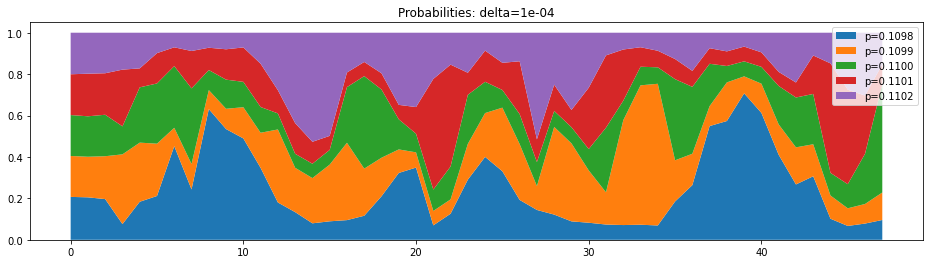

In [31]:
_ = run(delta=1e-4, hour_window=3, shift=3, support_rate=0.05, verbose=True)

p[0.09] = 0.075
p[0.1] = 0.078
p[0.11] = 0.089
p[0.12] = 0.143
p[0.13] = 0.616


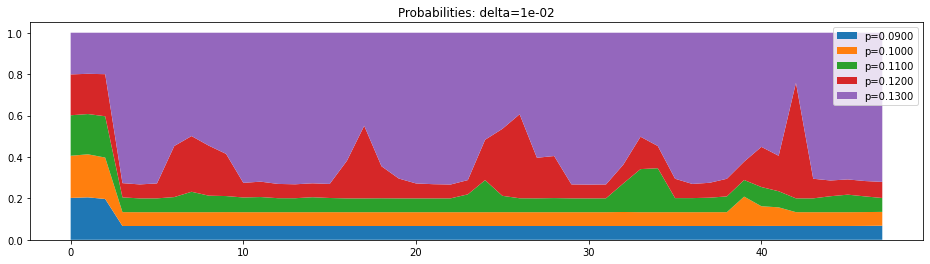

In [30]:
_ = run(delta=1e-2, hour_window=3, shift=3, support_rate=0.05, verbose=True)

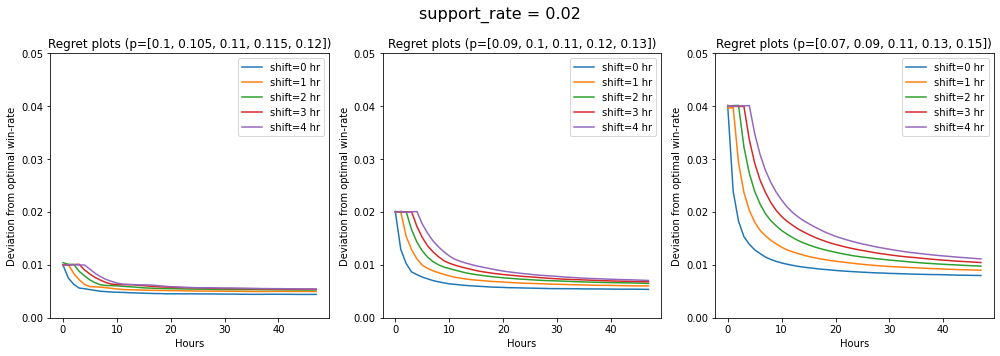

In [39]:
num_tries = 200
hour_window = 3
support_rate = 0.02

fig, axes = plt.subplots(1, 3, figsize=(14,5))

for idx, delta in enumerate([5e-3, 1e-2, 2e-2]):
    
#     max_val = 0
    ax = axes[idx]
    for shift in range(5):
        total_avg_regrets = np.zeros(24 * 2)
        for _ in range(num_tries):
            avg_regrets = run(delta, hour_window, shift, support_rate, verbose=False)
            total_avg_regrets += avg_regrets

        avg_avg_regrets = total_avg_regrets / num_tries
        ax.plot(avg_avg_regrets, label=f"shift={shift} hr")
        
#         max_val = max(max_val, avg_avg_regrets.max())

    p0 = 0.11    
    num_actions = 5
    probs = [p0 + (-(num_actions // 2) + i) * delta for i in range(num_actions)]

    ax.legend()
    ax.set_title(f"Regret plots (p={probs})")
    ax.set_xlabel("Hours")
    ax.set_ylabel("Deviation from optimal win-rate")
    ax.set_ylim(0, 0.05)

fig.suptitle(f"support_rate = {support_rate}", fontsize=16)
fig.tight_layout()
fig.savefig(f"../output/support_rate={support_rate}_winrate_regret.png", dpi=150, transparent=False)